<a href="https://colab.research.google.com/github/a-forty-two/EY_batch6_2ndSep24/blob/main/Sep24_002_Weights_and_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome back!

In this lab, we will observe how weights and bias are trained over epochs.

Let's begin with importing the libraries and read the dataset. We will also break the dataset into features and labels.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#IGNORE ANY WARNINGS THAT MAY APPEAR ON THIS CELL

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/a-forty-two/EY_batch6_2ndSep24/main/data.csv')

In [4]:
x = data[['radius_mean', 'smoothness_mean']]
y = data[['diagnosis']]

We are using the same dataset as in the last lab- view the inputs and labels.

In [5]:
x.head()

,radius_mean,smoothness_mean
0,17.99,0.11840
1,20.57,0.08474
2,19.69,0.10960
3,11.42,0.14250
4,20.29,0.10030


In [6]:
y.head()

,diagnosis
0,M
1,M
2,M
3,M
4,M


Using the same process as the last lab, we will normalize the inputs, and encode the labels.

Why do we normalize?

happiness = f(money, age)

age -> [0, 100]

money -> [ -$1,000,000,000 , $1,000,000,000 ]

h = w1*age + w2*money + bias

solution -> bring all in same level

age -> [-1,1]
money -> [-1 to 1]

many ways to do this:

1. Z-Score : (data - mean) / standard_deviation

scales everything on scale of (-inf, inf) such that the mean value becomes 0, and all others are adjusted as its ratio

From this, we create a scale of (-3, 3) which means 3 times of standard deviation is allowed!

Anything > 3 or < -3 is called an -> OUTLIER


2. Min Max : (data - min ) / (max - min)

Scale-> [ 0 to 1]

largest-> 1, smallest-> 0, everything else adjusted between them

Use case-> images -> [0,255] where each pixel is 1 byte or 0 to 255.

image normlization-> data / 255.0


3. Sigmoid: (use TF instead of formula)
Scale -> [0 to 1] BUT PROBABILISTIC unlike MinMAX!

4. TanH: hyperbolic tangent -> USE TF instead of formula

Scale -> [-1 to 1] -> probaility, classification




In [8]:
x.describe().T

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.7800,28.1100
smoothness_mean,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.1053,0.1634


In [9]:
#Normalize Input
stats = x.describe().T
mu, sigma = stats['mean'], stats['std']

In [10]:
x_norm = (x-mu)/sigma

In [11]:
x_norm

,radius_mean,smoothness_mean
0,1.096100,1.567087
1,1.828212,-0.826235
2,1.578499,0.941382
3,-0.768233,3.280667
4,1.748758,0.280125
...,...,...
564,2.109139,1.040926
565,1.703356,0.102368
566,0.701667,-0.839745
567,1.836725,1.524426


In [12]:
rule = lambda val: 1 if val=='M' else 0

In [13]:
y=y['diagnosis'].apply(rule)

In [14]:
y.tail()

,diagnosis
564,1
565,1
566,1
567,1
568,0


Now we will proceed to splitting the data. No changes so far-

In [15]:
HP_epochs = 200
HP_batch_size = 16
HP_lr = 0.001

In [17]:
xtrain,xtest,ytrain,ytest = train_test_split(x_norm,y,random_state=42, test_size=0.2)

Our dataset is small. But for big data, or larger datasets, we can use TensorFlow's Dataset API.
<br/>
We additionally shuffle the dataset to provide randomness.

Because we are going to simulate the training process over epochs, we will also repeat our dataset.

We will also divide our data into fixed size batches.

In [18]:
celldata = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
celldata = celldata.shuffle(100).repeat(HP_epochs).batch(HP_batch_size)

This is the simplest way to create a dataset.

dataset = tf.data.Dataset.from_tensor_slices(any_tensor_or_numpy_array_or_pandas_dataset)

Now we will place an iterator on top of our dataset to loop into the actual data.

In [19]:
itr = celldata.__iter__()
#IGNORE ANY WARNINGS THAT MAY APPEAR ON THIS CELL

Now, we will initialize our weights and bias. We are initializing the weights with random numbers, normally distributed from the mean 0, with a standard deviation of 0.5.


In [20]:
# we have only 2 features and 1 label
# One weight for each feature
w = tf.random.normal( ( 2 , 1 ), mean = 0, stddev =0.5,dtype=tf.dtypes.double )
# One bias for every output
# our only output is the label prediction on 1 layer
b = 0

Have a look at the initial weights

In [21]:
print(w)

tf.Tensor(
[[0.11338689]
 [0.52228565]], shape=(2, 1), dtype=float64)


In [22]:
# define an empty array to store all the errors
# errors will be generated from each training simulation
err = []

Let's define a dummy classifier to encode our predictions into 1 and 0

In [23]:

def myclassifier(vals):
  res = []
  rule = lambda r: 1.0 if r>=0.5 else 0.0
  for val in vals:
    res.append(rule(val))
  return res


And let's begin the training simulation!

TensorFlow functions to observe


*   tensordot - returns dot product
*   cast - datatype casting on tensors
*   reduce_mean - mean of TensorFlow datasets



In [24]:
itrs_per_epoch = int(len(xtrain)/HP_batch_size)
# Each iteration represents 1 epoch
for i in range(HP_epochs):
  per_iter_err = []
  for j in range(itrs_per_epoch):
    # get data and labels in fixed batch sizes
    data, labels = itr.get_next()

    # simplest representation of ML
    # y = mx + c
    y = tf.tensordot(data, w, axes=1) + b
    # decode the results, and typecast to double
    y = myclassifier(y)
    y = tf.cast(y, tf.dtypes.double)
    # typecast the known labels to double
    labels = tf.cast(labels, tf.dtypes.double)
    # calculate the error
    avg_error = tf.reduce_mean(tf.square(y - labels))
    per_iter_err.append(avg_error)
    mse_derivative = tf.reduce_mean(2 * ( y - labels ))

    # update the weights and bias for the next epoch
    weight_update = tf.reduce_mean(mse_derivative*data)
    bias_update = tf.reduce_mean(mse_derivative)

    w = w - HP_lr * weight_update
    b = b - HP_lr * bias_update
    # end of iteration simulation

  final_epoch_error = np.array(per_iter_err).mean()
  err.append(final_epoch_error)
  #end of epoch simulation

  print('****')
  print('For epoch ',i+1,', the weights = ', w)


****
For epoch  1 , the weights =  tf.Tensor(
[[0.11337704]
 [0.52227579]], shape=(2, 1), dtype=float64)
****
For epoch  2 , the weights =  tf.Tensor(
[[0.1133142 ]
 [0.52221295]], shape=(2, 1), dtype=float64)
****
For epoch  3 , the weights =  tf.Tensor(
[[0.11283862]
 [0.52173738]], shape=(2, 1), dtype=float64)
****
For epoch  4 , the weights =  tf.Tensor(
[[0.11301026]
 [0.52190901]], shape=(2, 1), dtype=float64)
****
For epoch  5 , the weights =  tf.Tensor(
[[0.11328234]
 [0.5221811 ]], shape=(2, 1), dtype=float64)
****
For epoch  6 , the weights =  tf.Tensor(
[[0.11384226]
 [0.52274101]], shape=(2, 1), dtype=float64)
****
For epoch  7 , the weights =  tf.Tensor(
[[0.11364901]
 [0.52254776]], shape=(2, 1), dtype=float64)
****
For epoch  8 , the weights =  tf.Tensor(
[[0.11321396]
 [0.52211271]], shape=(2, 1), dtype=float64)
****
For epoch  9 , the weights =  tf.Tensor(
[[0.11307224]
 [0.52197099]], shape=(2, 1), dtype=float64)
****
For epoch  10 , the weights =  tf.Tensor(
[[0.1136

Phew! Observed how weights and bias correct themselves on each iteration, and each epoch? It's a long process!

Let's observe how the loss dropped over a period of time- on the y-axis we have the loss (mean squared error), and epochs on the x-axis

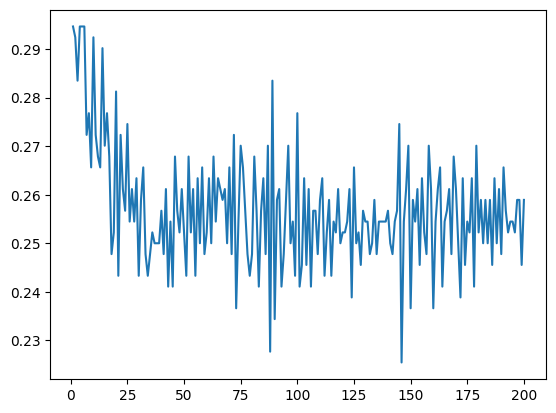

In [25]:
import matplotlib.pyplot as plt
time_axis = range(1,len(err)+1)
plt.plot(  time_axis, err)
plt.show()

After this, we can locate the point on the graph with minimum y (because this is an error). That's the point at which we can then retrain the model.

**Conclusion**

In this module we achieved the following:



*   Revised the model training process
*   Simulated the model training
*   Observed inbuilt TensorFlow functions
*   Initialized weights and bias
*   Observed their updates over iterations and epochs
*   Calculated and plotted the errors over epochs

